# Imports

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import normaltest
import warnings

warnings.filterwarnings('ignore')
significance = 0.05

# Helpers Methods - Candidate to be a py file

In [132]:
def get_frequences_by_column(dataframe, column, sturger_class):
    frequence = pd.value_counts(
        pd.cut(
            x = dataframe[column],
            bins = sturger_class,
            include_lowest = True
        ),
        sort = False
    )
    return frequence

def get_percentage_by_column(dataframe, column, sturger_class):
    percentage = pd.value_counts(
        pd.cut(
            x = dataframe[column],
            bins = sturger_class,
            include_lowest = True
        ),
        sort = False,
        normalize = True
    )
    return percentage

def print_media_median_mode(dataframe, column):
    print(f'Mean is {dataframe[column].mean()} \nMedian is {dataframe[column].median()}\nMode is {dataframe[column].mode()[0]}')


def jaccard_generalized(groups, lines):
    '''
        E se a divisão for zero
    '''
    jaccard_distance_matrix = np.empty((lines,lines))
    countOff = 0
    for _ in groups.tolist():
        countIn = 0
        for _ in groups.tolist():
            numerator = float(np.sum(np.minimum(groups[countOff, :], groups[countOff, :])))
            denominator = float(np.sum(np.maximum(groups[countOff, :], groups[countIn, :])))
            if denominator != 0:
                jaccard_distance_matrix[countOff, countIn] = numerator / denominator
            countIn += 1
        countOff += 1
    
    return jaccard_distance_matrix

# Reading

In [126]:
dataframe = pd.read_csv ('hotel_bookings.csv')

# Description

In [127]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

**hotel**                           Hotel (H1 = Resort Hotel or H2 = City Hotel)  
**is canceled**                     Value indicating if the booking was canceled (1) or not (0)  
**lead_time**                       days between the entering date of the booking into the PMS and the arrival date  
**arrival_date_year**               Year of arrival date  
**arrival_date_month**              Month of arrival date  
**arrival_date_week_number**        Week number of year for arrival date  
**arrival_date_day_of_month**       Day of arrival date  
**stays_in_weekend_nights**         Number of weekend nights(Sat or Sun)the guest stayed or booked to stay at the hotel  
**stays_in_week_nights**            Number of week nights (Mon to Fri) the guest stayed or booked to stay at the hotel  
**adults**                          Number of adults  
**children**                        Number of children  
**babies**                          Number of babies  
**meal**                            Type of meal booked. Standard hospitality meal packages: Undefined/SC – no meal  
**country**                         Categories are represented in the ISO 3155–3:2013 format  
**market_segment**                  Market segment designation. “TA” - “Travel Agents” and “TO” - “Tour Operators”  
**distribution_channel**            Booking distribution. The term “TA” - “Travel Agents” and “TO” - “Tour Operators”  
**is_repeated_guest**               Value indicating if the booking name was from a repeated guest (1) or not (0)  
**previous_cancellations**          Number of previous bookings that were cancelled by the customer  
**previous_bookings_not_canceled**  Number of previous bookings not cancelled by the customer  
**reserved_room_type**              Code of room type reserved  
**assigned_room_type**              Code for the type of room assigned to the booking  
**booking_changes**                 Changes made to the booking from the moment the booking was entered   
**deposit_type**                    Indication on if the customer made a deposit to guarantee the booking  
**agent**                           ID of the travel agency that made the booking  
**company**                         ID of the company/entity that made the booking  
**days_in_waiting_list**            Number of days the booking was in the waiting list  
**customer_type**                   Type of booking, assuming one of four categories  
**adr**                             Average Daily Rate as defined by dividing the sum of all lodging transactions  
**required_car_parking_spaces**     Number of car parking spaces required by the customer    
**total_of_special_requests**       Number of special requests made by the customer (e.g. twin bed or high floor)  
**reservation_status**              Reservation last status, assuming one of three categories  
**reservation_status_date**         Date at which the last status was set  

# Exploring

In [34]:

dataframe.head()
dataframe[dataframe['country'] == 'ESP']
dataframe[dataframe['country'] == 'PRT']


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.00,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.00,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.00,0,1,Canceled,2015-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119317,City Hotel,0,188,2017,August,35,30,0,4,3,...,No Deposit,15.0,NaN,0,Transient,129.60,0,0,Check-Out,2017-09-03
119340,City Hotel,0,110,2017,August,35,29,0,5,2,...,No Deposit,14.0,NaN,0,Transient,171.00,0,2,Check-Out,2017-09-03
119357,City Hotel,0,47,2017,August,35,31,1,3,1,...,No Deposit,423.0,NaN,0,Transient,91.02,0,0,Check-Out,2017-09-04
119366,City Hotel,0,210,2017,August,35,28,2,5,2,...,No Deposit,7.0,NaN,0,Transient,85.59,0,1,Check-Out,2017-09-04


# Sturges rule to class
## k = 1 + (10/3 log₁₀ n)

In [35]:
class_number = 1 + (10 /3) * np.log10(dataframe.shape[0])
class_number = int(class_number.round(0))
class_number

18

## lead_time

In [53]:
distribution_frequences_lead_time = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'lead_time', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'lead_time', class_number)}
)
distribution_frequences_lead_time.rename_axis('Lead Time', axis= 'columns', inplace = True)
statistics_test_lead_time, p_value_lead_time = normaltest(dataframe["lead_time"])

print_media_median_mode(dataframe, "lead_time")
print('Not a normal distribution' if p_value_lead_time <= significance else 'It"s normal distribution')
distribution_frequences_lead_time

Mean is 104.01141636652986 
Median is 69.0
Mode is 0
Not a normal distribution


Lead Time,Frequence,Porcentage (%)
"(-0.738, 40.944]",45513,0.381213
"(40.944, 81.889]",19319,0.161814
"(81.889, 122.833]",14413,0.120722
"(122.833, 163.778]",11073,0.092746
"(163.778, 204.722]",9034,0.075668
"(204.722, 245.667]",5939,0.049745
"(245.667, 286.611]",4932,0.041310
"(286.611, 327.556]",3826,0.032046
"(327.556, 368.5]",2261,0.018938
"(368.5, 409.444]",1168,0.009783


### Graphs - lead_time

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

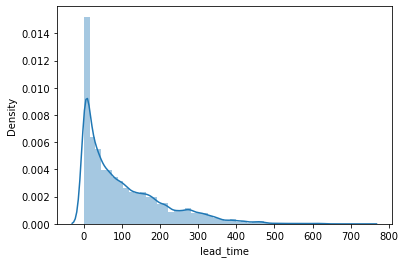

In [67]:
sns.distplot(dataframe["lead_time"])

<AxesSubplot:xlabel='lead_time'>

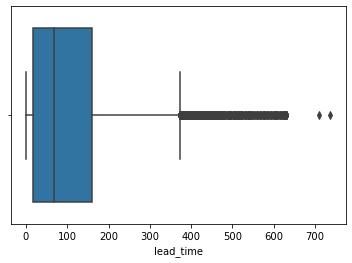

In [68]:
sns.boxplot(x = 'lead_time', data = dataframe, orient = 'h')

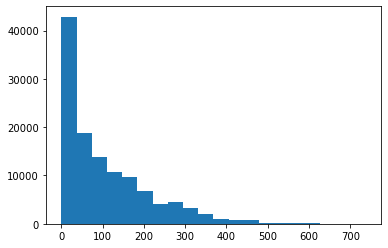

In [69]:
plt.hist(dataframe["lead_time"], bins=20)
plt.show()

## hotel

In [72]:
frequence_hotel = dataframe['hotel'].value_counts()
percentage_hotel = dataframe['hotel'].value_counts(normalize = True) * 100
distribution_frequence_hotel = pd.DataFrame({'Frequence': frequence_hotel, 'Percentage (%)': percentage_hotel})
distribution_frequence_hotel.rename_axis('Hotel Type', axis= 'columns', inplace = True)

distribution_frequence_hotel

Hotel Type,Frequence,Percentage (%)
City Hotel,79330,66.446101
Resort Hotel,40060,33.553899


### Graphs - hotel

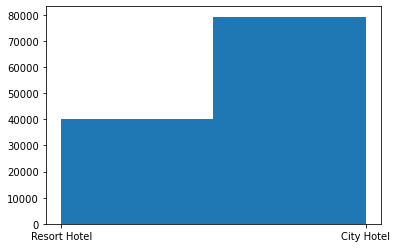

In [73]:
plt.hist(dataframe["hotel"], bins=2)
plt.show()

## adults

In [75]:
distribution_frequences_adults = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'adults', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'adults', class_number)}
)

distribution_frequences_adults.rename_axis('Adults', axis= 'columns', inplace = True)
print_media_median_mode(dataframe, "adults")
statistics_test_adults, p_value_adults = normaltest(dataframe["adults"])
print('Not a normal distribution' if p_value_adults <= significance else 'It"s normal distribution')
distribution_frequences_adults

Mean is 1.8564033838679956 
Median is 2.0
Mode is 2
Not a normal distribution


Adults,Frequence,Porcentage (%)
"(-0.056, 3.056]",119312,0.999347
"(3.056, 6.111]",65,0.000544
"(6.111, 9.167]",0,0.000000
"(9.167, 12.222]",1,0.000008
"(12.222, 15.278]",0,0.000000
"(15.278, 18.333]",0,0.000000
"(18.333, 21.389]",2,0.000017
"(21.389, 24.444]",0,0.000000
"(24.444, 27.5]",7,0.000059
"(27.5, 30.556]",0,0.000000


### Graphs - adults

<AxesSubplot:xlabel='adults', ylabel='Density'>

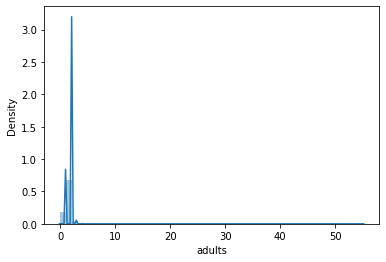

In [76]:
sns.distplot(dataframe["adults"])

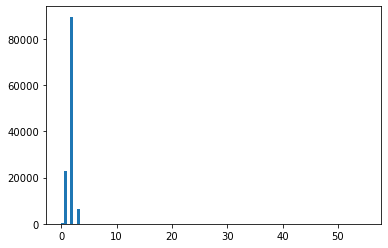

In [77]:
plt.hist(dataframe["adults"], bins=100)
plt.show()

## children

In [79]:
distribution_frequences_children = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'children', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'children', class_number)}
)
distribution_frequences_children.rename_axis('Children', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "children")
statistics_test_children, p_value_children = normaltest(dataframe["children"])
print('Not a normal distribution' if p_value_children <= significance else 'It"s normal distribution')
distribution_frequences_children

Mean is 0.10388990333874994 
Median is 0.0
Mode is 0.0
It"s normal distribution


Children,Frequence,Porcentage (%)
"(-0.011, 0.556]",110796,0.928049
"(0.556, 1.111]",4861,0.040717
"(1.111, 1.667]",0,0.000000
"(1.667, 2.222]",3652,0.030590
"(2.222, 2.778]",0,0.000000
"(2.778, 3.333]",76,0.000637
"(3.333, 3.889]",0,0.000000
"(3.889, 4.444]",0,0.000000
"(4.444, 5.0]",0,0.000000
"(5.0, 5.556]",0,0.000000


### Graphs - children

<AxesSubplot:xlabel='children', ylabel='Density'>

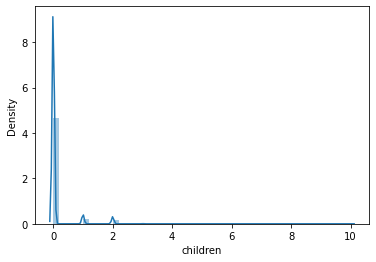

In [81]:
sns.distplot(dataframe['children'])

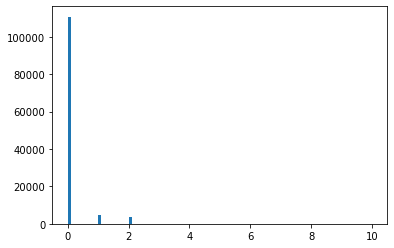

In [80]:
plt.hist(dataframe["children"], bins=100)
plt.show()

## babies

In [82]:
distribution_frequences_babies = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'babies', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'babies', class_number)}
)
distribution_frequences_babies.rename_axis('Babies', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "babies")

statistics_test_babies, p_value_babies = normaltest(dataframe["babies"])
print('Not a normal distribution' if p_value_babies <= significance else 'It"s normal distribution')
distribution_frequences_babies

Mean is 0.007948739425412514 
Median is 0.0
Mode is 0
Not a normal distribution


Babies,Frequence,Porcentage (%)
"(-0.011, 0.556]",118473,0.992319
"(0.556, 1.111]",900,0.007538
"(1.111, 1.667]",0,0.000000
"(1.667, 2.222]",15,0.000126
"(2.222, 2.778]",0,0.000000
"(2.778, 3.333]",0,0.000000
"(3.333, 3.889]",0,0.000000
"(3.889, 4.444]",0,0.000000
"(4.444, 5.0]",0,0.000000
"(5.0, 5.556]",0,0.000000


### Graphs - babies

<AxesSubplot:xlabel='babies', ylabel='Density'>

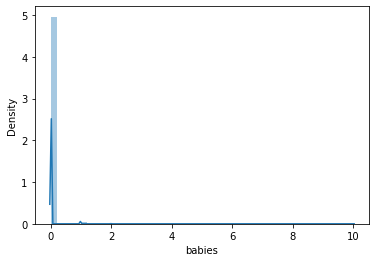

In [84]:
sns.distplot(dataframe["babies"])

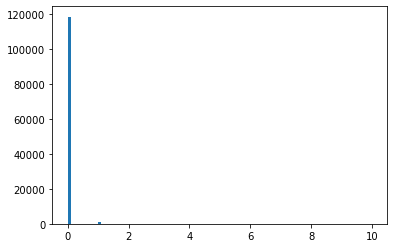

In [85]:
plt.hist(dataframe["babies"], bins=100)
plt.show()

## arrival_date_week_number

In [86]:
distribution_frequences_arrival_date_week_number = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'arrival_date_week_number', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'arrival_date_week_number', class_number)}
)
distribution_frequences_arrival_date_week_number.rename_axis('Arrival Date Week', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "arrival_date_week_number")

statistics_test_arrival_date_week_number, p_value_arrival_date_week_number = normaltest(dataframe["arrival_date_week_number"])
print('Not a normal distribution' if p_value_arrival_date_week_number <= significance else 'It"s normal distribution')
distribution_frequences_arrival_date_week_number

Mean is 27.16517296255968 
Median is 28.0
Mode is 33
Not a normal distribution


Arrival Date Week,Frequence,Porcentage (%)
"(0.947, 3.889]",3584,0.030019
"(3.889, 6.778]",4382,0.036703
"(6.778, 9.667]",6442,0.053958
"(9.667, 12.556]",6302,0.052785
"(12.556, 15.444]",7369,0.061722
"(15.444, 18.333]",8136,0.068146
"(18.333, 21.222]",8041,0.067351
"(21.222, 24.111]",7665,0.064201
"(24.111, 27.0]",7718,0.064645
"(27.0, 29.889]",5616,0.047039


### Graphs - arrival_date_week_number

<AxesSubplot:xlabel='arrival_date_week_number', ylabel='Density'>

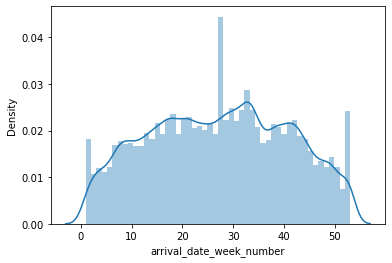

In [87]:
sns.distplot(dataframe["arrival_date_week_number"])

<AxesSubplot:xlabel='arrival_date_week_number'>

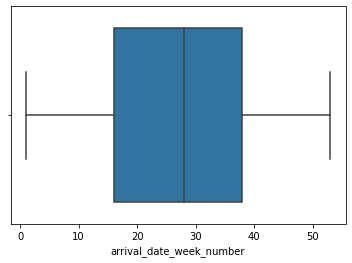

In [89]:
sns.boxplot( x = 'arrival_date_week_number', data = dataframe, orient = 'h')

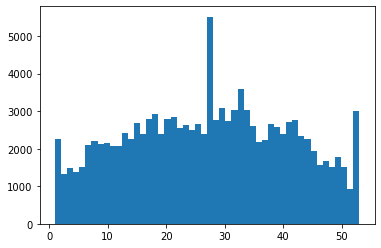

In [90]:
plt.hist(dataframe["arrival_date_week_number"], bins=50)
plt.show()

## stays_in_week_nights

In [91]:
distribution_frequences_stays_in_week_nights = pd.DataFrame(
    {'Frequence': get_frequences_by_column(dataframe, 'stays_in_week_nights', class_number), 
     'Porcentage (%)': get_percentage_by_column(dataframe, 'stays_in_week_nights', class_number)}
)
distribution_frequences_stays_in_week_nights.rename_axis('Stays in Week Nights', axis= 'columns', inplace = True)

print_media_median_mode(dataframe, "stays_in_week_nights")

statistics_test_arrival_stays_in_week_nights, p_value_stays_in_week_nights = normaltest(dataframe["stays_in_week_nights"])
print('Not a normal distribution' if p_value_stays_in_week_nights <= significance else 'It"s normal distribution')
distribution_frequences_stays_in_week_nights

Mean is 2.500301532791691 
Median is 2.0
Mode is 2
Not a normal distribution


Stays in Week Nights,Frequence,Porcentage (%)
"(-0.051000000000000004, 2.778]",71639,0.600042
"(2.778, 5.556]",42898,0.359310
"(5.556, 8.333]",3184,0.026669
"(8.333, 11.111]",1323,0.011081
"(11.111, 13.889]",69,0.000578
"(13.889, 16.667]",136,0.001139
"(16.667, 19.444]",54,0.000452
"(19.444, 22.222]",63,0.000528
"(22.222, 25.0]",9,0.000075
"(25.0, 27.778]",1,0.000008


### Graphs - stays_in_week_nights

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

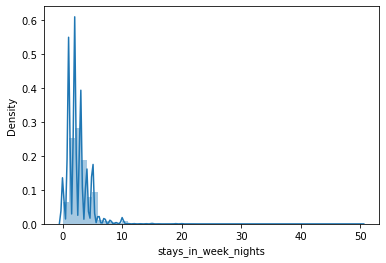

In [92]:
sns.distplot(dataframe["stays_in_week_nights"])

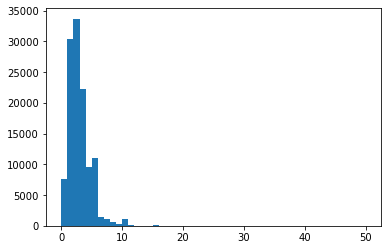

In [93]:
plt.hist(dataframe["stays_in_week_nights"], bins=50)
plt.show()

## reservation_status_date

### Graphs - reservation_status_date

In [ ]:
plt.hist(dataframe["reservation_status_date"], bins=50)
plt.show()

# Questions

## **reservas canceladas com criancas incluidas na reserva?**
## **Época do Ano/Mês/Semana com mais reservas por Tipologia**
## **% de cancelamentos por ano/mês/semana por tipologia**
## **Época do Ano/Mês/Semana chegadas (Reservas sem cancelamento) por Tipologia (Reservas - cancelamento = chegadas)**
## **Permanencia de dias (ao fim-de-semana e/ou durante a semana) por tipologia**
## **Quem reservou? Operador turistico e/ou agente de viagens ou outros**

# Candidates variables to Jaccard Test

## Qual a similiaridade entre o numero de cancelamentos e Os clientes frequentes.
## Canceled Value indicating if the booking was canceled (1) or not (0)
## Repeated_guest Value indicating if the booking name was from a repeated guest (1) or not (0)
# meal Type of meal booked. Standard hospitality meal packages: Undefined/SC – no meal

In [157]:
matrix = jaccard_generalized(dataframe[["is_canceled", "is_repeated_guest"]].head(20).values, 20)

In [158]:
matrix

array([[0.00000000e+000, 6.94077642e-310, 0.00000000e+000,
        6.94078967e-310, 6.94078966e-310, 6.94077993e-310,
        6.94077639e-310, 6.94078967e-310, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 6.94077993e-310,
        6.94078967e-310, 6.94078966e-310, 6.94077993e-310,
        6.94077639e-310, 6.94078967e-310, 6.94077636e-310,
        6.94078966e-310, 6.94077642e-310],
       [6.94077993e-310, 6.94078967e-310, 6.94078966e-310,
        6.94077993e-310, 6.94077639e-310, 6.94078967e-310,
        6.94077636e-310, 6.94078966e-310, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 6.94078966e-310,
        6.94077966e-310, 6.94077639e-310, 6.94078967e-310,
        6.94077636e-310, 6.94078966e-310, 6.94077642e-310,
        6.94077966e-310, 6.94078967e-310],
       [6.94078966e-310, 6.94077966e-310, 6.94077639e-310,
        6.94078967e-310, 6.94077636e-310, 6.94078966e-310,
        6.94077642e-310, 6.94077966e-310, 0.00000000e+000,
        0.00000000e+000, 0.00

In [159]:
print(matrix)

[[0.00000000e+000 6.94077642e-310 0.00000000e+000 6.94078967e-310
  6.94078966e-310 6.94077993e-310 6.94077639e-310 6.94078967e-310
  0.00000000e+000 0.00000000e+000 0.00000000e+000 6.94077993e-310
  6.94078967e-310 6.94078966e-310 6.94077993e-310 6.94077639e-310
  6.94078967e-310 6.94077636e-310 6.94078966e-310 6.94077642e-310]
 [6.94077993e-310 6.94078967e-310 6.94078966e-310 6.94077993e-310
  6.94077639e-310 6.94078967e-310 6.94077636e-310 6.94078966e-310
  0.00000000e+000 0.00000000e+000 0.00000000e+000 6.94078966e-310
  6.94077966e-310 6.94077639e-310 6.94078967e-310 6.94077636e-310
  6.94078966e-310 6.94077642e-310 6.94077966e-310 6.94078967e-310]
 [6.94078966e-310 6.94077966e-310 6.94077639e-310 6.94078967e-310
  6.94077636e-310 6.94078966e-310 6.94077642e-310 6.94077966e-310
  0.00000000e+000 0.00000000e+000 0.00000000e+000 6.94077639e-310
  6.94078967e-310 6.94077636e-310 6.94078966e-310 6.94077642e-310
  6.94077966e-310 6.94078967e-310 6.94078966e-310 6.94077966e-310]
 [6.940

In [160]:
def jaccardG(BP):
    n = BP.shape[0]
    P = np.empty((n,n))
    i = 0
    for useri in BP_p.tolist():
        j = 0
        for userj in BP_p.tolist():
            if float(np.sum(np.maximum(BP_p[i,:],BP_p[j,:]))) != 0:
                P[i,j] = float(np.sum(np.minimum(BP_p[i,:],BP_p[j,:])))/float(np.sum(np.maximum(BP_p[i,:],BP_p[j,:])))
            j =j + 1
        i = i + 1
    
    return P

In [161]:
BP_p = dataframe[["is_canceled", "babies"]].head(100).values

In [162]:
BP_p.tolist()

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [1, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

In [163]:
B = jaccardG(BP_p)

In [164]:
B

array([[0.00000000e+000, 6.94071015e-310, 6.94071015e-310, ...,
        6.94078962e-310, 6.94071015e-310, 6.94078962e-310],
       [6.94071015e-310, 6.94078962e-310, 6.94071015e-310, ...,
        6.94078962e-310, 6.94071015e-310, 6.94078962e-310],
       [6.94071015e-310, 6.94078962e-310, 6.94071015e-310, ...,
        6.94078962e-310, 6.94071015e-310, 6.94078962e-310],
       ...,
       [9.88131292e-324, 0.00000000e+000, 6.94071016e-310, ...,
        0.00000000e+000, 6.94071016e-310, 0.00000000e+000],
       [0.00000000e+000, 2.15869983e-314, 9.88131292e-324, ...,
        2.15869983e-314, 9.88131292e-324, 6.94071016e-310],
       [9.88131292e-324, 0.00000000e+000, 6.94071016e-310, ...,
        0.00000000e+000, 6.94071016e-310, 0.00000000e+000]])

In [165]:
np.sum(B>0)

5263

In [166]:
# teste